In [3]:
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
# Explainability
import shap

# Gemini API
import google.generativeai as genai

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/sj/gg2grkd107n2cv3c8zq0ppvm0000gn/T/ipykernel_8217/1509925615.py:5: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [ ]:
df = pd.read_csv("indian_aqi_health_impact_2019_2024.csv")  
df.head()

,City,AQI,PM2.5,PM10,NO2,CO,SO2,O3,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Pressure (hPa),Vehicle Count,Industrial Activity Index,Health Impact Score
0,Rajkot,59,227.411137,160.372399,44.820603,5.985617,37.125197,58.063991,11.923333,64.424980,12.921405,14.473955,976.426573,198941,4.862272,10
1,Bangalore,443,219.714245,279.801260,78.175010,5.061981,27.136555,40.777526,16.738252,23.112364,19.405409,34.790048,1022.471409,35588,5.260538,10
2,Bhopal,56,94.849259,262.324427,70.018054,6.589327,34.627094,42.726937,30.388482,63.634393,13.412998,194.360799,984.562478,430785,3.799079,10
3,Srinagar,342,120.983287,213.374289,71.842615,4.443049,32.297618,97.020499,32.694605,69.655615,19.225225,233.854741,950.209304,209382,4.426706,10
4,Hyderabad,492,184.262288,165.108731,16.167775,0.553949,6.722572,22.823065,12.514916,93.221730,10.368030,91.751966,1021.432263,257650,9.349909,10


In [35]:
df.shape

(10000, 16)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   City                       10000 non-null  object 
 1   AQI                        10000 non-null  int64  
 2   PM2.5                      10000 non-null  float64
 3   PM10                       10000 non-null  float64
 4   NO2                        10000 non-null  float64
 5   CO                         10000 non-null  float64
 6   SO2                        10000 non-null  float64
 7   O3                         10000 non-null  float64
 8   Temperature (°C)           10000 non-null  float64
 9   Humidity (%)               10000 non-null  float64
 10  Wind Speed (km/h)          10000 non-null  float64
 11  Rainfall (mm)              10000 non-null  float64
 12  Pressure (hPa)             10000 non-null  float64
 13  Vehicle Count              10000 non-null  int6

In [37]:
df = df.drop_duplicates()

numeric_cols = df.columns.drop("City")
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

print(df.isnull().sum())

City                         0
AQI                          0
PM2.5                        0
PM10                         0
NO2                          0
CO                           0
SO2                          0
O3                           0
Temperature (°C)             0
Humidity (%)                 0
Wind Speed (km/h)            0
Rainfall (mm)                0
Pressure (hPa)               0
Vehicle Count                0
Industrial Activity Index    0
Health Impact Score          0
dtype: int64


### EXPLORATORY DATA ANALYSIS
  Correlation with AQI


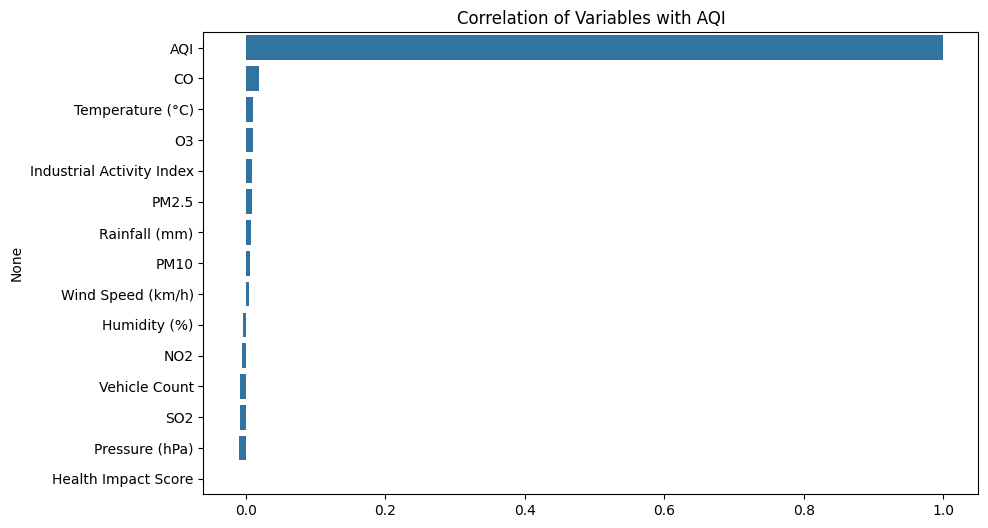

In [25]:
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)["AQI"].sort_values(ascending=False)
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Variables with AQI")
plt.show()

### CREATE POLLUTION SEVERITY INDEX (PSI)

In [38]:
df["PSI"] = (
    0.4 * df["PM2.5"] +
    0.25 * df["PM10"] +
    0.15 * df["NO2"] +
    0.10 * df["CO"] +
    0.05 * df["SO2"] +
    0.05 * df["O3"]
)

In [41]:
df.head()

,City,AQI,PM2.5,PM10,NO2,CO,SO2,O3,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Pressure (hPa),Vehicle Count,Industrial Activity Index,Health Impact Score,PSI
0,Rajkot,59,227.411137,160.372399,44.820603,5.985617,37.125197,58.063991,11.923333,64.424980,12.921405,14.473955,976.426573,198941,4.862272,10,143.138666
1,Bangalore,443,219.714245,279.801260,78.175010,5.061981,27.136555,40.777526,16.738252,23.112364,19.405409,34.790048,1022.471409,35588,5.260538,10,173.464167
2,Bhopal,56,94.849259,262.324427,70.018054,6.589327,34.627094,42.726937,30.388482,63.634393,13.412998,194.360799,984.562478,430785,3.799079,10,118.550153
3,Srinagar,342,120.983287,213.374289,71.842615,4.443049,32.297618,97.020499,32.694605,69.655615,19.225225,233.854741,950.209304,209382,4.426706,10,119.423490
4,Hyderabad,492,184.262288,165.108731,16.167775,0.553949,6.722572,22.823065,12.514916,93.221730,10.368030,91.751966,1021.432263,257650,9.349909,10,118.939941


In [39]:
features = [
    "PM2.5","PM10","NO2","CO","SO2","O3",
    "Temperature (°C)","Humidity (%)",
    "Wind Speed (km/h)","Rainfall (mm)",
    "Pressure (hPa)","Vehicle Count"
]

X = df[features]
y = df["PSI"]

### Random Forest 

In [40]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42
)

model.fit(X, y)

,n_estimators,300
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
explainer = shap.TreeExplainer(model)

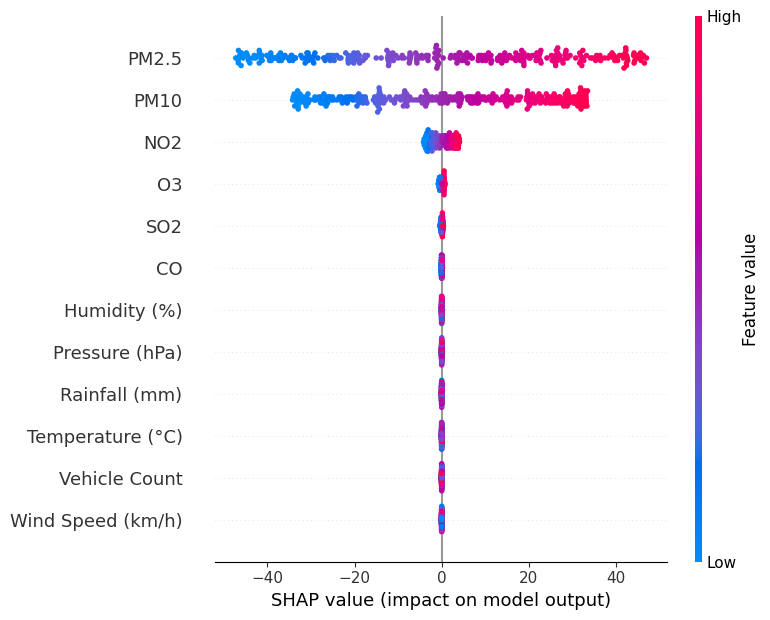

In [55]:
shap_values = explainer.shap_values(X.sample(300, random_state=42))

shap.summary_plot(shap_values, X.sample(300, random_state=42))

SHAP analysis shows that PM2.5 and PM10 are the dominant drivers of pollution severity, while traffic-related gases and meteorological factors play secondary roles.Explainability analysis using SHAP demonstrates that particulate matter is the primary contributor to pollution severity, validating both the constructed Pollution Severity Index and the rule-based cause attribution logic.

In [43]:
def aqi_category(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

In [44]:
def cigarette_equivalent(pm25):
    return round(pm25 / 22, 1)

In [45]:
def identify_causes(row):
    causes = []

    if row["PM2.5"] > 100 and row["PM10"] > 150:
        causes.append("Construction and road dust")

    if (row["NO2"] > 60 or row["CO"] > 3) and row["Vehicle Count"] > df["Vehicle Count"].quantile(0.75):
        causes.append("Heavy traffic congestion")

    if row["SO2"] > 40:
        causes.append("Industrial emissions")

    if row["Wind Speed (km/h)"] < 5:
        causes.append("Low wind speed trapping pollutants")

    if row["O3"] > 80 and row["Temperature (°C)"] > 30:
        causes.append("Photochemical smog due to high temperature")

    return causes

In [46]:
def precaution_advice(aqi, causes):
    precautions = []

    if aqi > 200:
        precautions += [
            "Avoid outdoor exercise",
            "Wear N95 masks",
            "Keep windows closed"
        ]

    if "traffic" in " ".join(causes).lower():
        precautions.append("Avoid peak traffic hours")

    if "construction" in " ".join(causes).lower():
        precautions.append("Use air purifiers indoors")

    if not precautions:
        precautions.append("No special precautions required")

    return precautions

In [ ]:
genai.configure(api_key=key)

gemini_model = genai.GenerativeModel("models/gemini-flash-latest")

In [ ]:
# model = genai.GenerativeModel("models/gemini-flash-latest")

# response = model.generate_content("Hello! This is free Gemini response.")
# print(response.text)

E0000 00:00:1767560883.691726  762151 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Hello! That's correct, you're interacting with a large language model trained by Google, often referred to as Gemini.

**How can I help you today?** Is there something you'd like to discuss, write, research, brainstorm, or just chat about?


In [50]:
def generate_air_quality_report(user_data):
    user_df = pd.DataFrame([user_data])[features]

    # ML Explainability
    shap_values = explainer.shap_values(user_df)
    shap_df = pd.DataFrame({
        "Feature": features,
        "Impact": np.abs(shap_values[0])
    }).sort_values(by="Impact", ascending=False)

    top_factors = shap_df.head(4)

    # Rule-based reasoning
    causes = identify_causes(user_data)

    # Health interpretation
    aqi = user_data["AQI"]
    category = aqi_category(aqi)
    cigarettes = cigarette_equivalent(user_data["PM2.5"])
    precautions = precaution_advice(aqi, causes)

    # Gemini Prompt
    prompt = f"""
You are an environmental health analyst.

City: {user_data['City']}
AQI: {aqi} ({category})

Top contributing variables:
{top_factors.to_string(index=False)}

Identified real-world causes:
{', '.join(causes)}

Health exposure:
PM2.5 exposure ≈ {cigarettes} cigarettes per day

Precautions:
{', '.join(precautions)}

Write a clear, public-friendly report explaining:
1. Why AQI is high
2. What caused it
3. Health risks
4. Immediate precautions

Avoid technical jargon.
"""

    response = gemini_model.generate_content(prompt)
    return response.text

### Output Example 1

In [ ]:
user_input = {
    "City": "Kolkata",
    "AQI": 316,
    "PM2.5": 120,
    "PM10": 204,
    "NO2": 40,
    "CO": 912,
    "SO2": 42,
    "O3": 55,   #not ppb
    "Temperature (°C)": 31,
    "Humidity (%)": 78,
    "Wind Speed (km/h)": 4.2,
    "Rainfall (mm)": 0.0,
    "Pressure (hPa)": 1007,
    "Vehicle Count": 340000
}

In [52]:
report = generate_air_quality_report(user_input)
print(report)

## Public Health Alert: Severe Air Quality in Kolkata

**Date of Report:** [Insert Current Date]
**City:** Kolkata
**Current Air Quality Index (AQI):** 312 (Very Poor)

---

As an Environmental Health Analyst, I must inform the public that Kolkata is currently experiencing **Severe** air quality conditions. The air is highly toxic and poses an immediate and serious risk to the health of all residents.

We urge everyone to take immediate action to protect themselves and their families.

---

### 1. Why the Air Quality is Dangerous

The current Air Quality Index (AQI) is 312, which falls into the **"Very Poor"** category.

An AQI this high means the air is hazardous. It is dangerous for healthy individuals to spend time outside, and people with existing heart or lung conditions face critically high risks of severe symptoms, illness, or hospitalization.

The core issue is the overwhelming concentration of extremely tiny dust and soot particles, known as particulate matter (PM10 and PM2.5)

### Output Example 2

In [ ]:
user_input = {
    "City": "Kolkata",
    "AQI": 312,
    "PM2.5": 186,
    "PM10": 270,
    "NO2": 68,
    "CO": 1.5,
    "SO2": 5.2,
    "O3": 15.7,
    "Temperature (°C)": 12,
    "Humidity (%)": 93,
    "Wind Speed (km/h)": 8,
    "Rainfall (mm)": 0.0,
    "Pressure (hPa)": 1018,
    "Vehicle Count": 340000
}

In [54]:
report = generate_air_quality_report(user_input)
print(report)

# URGENT Air Quality Alert for Kolkata

**Date:** [Insert Current Date]
**Issued By:** Environmental Health Analysis Team

This report summarizes the immediate risks and necessary precautions for the city of Kolkata following a severe deterioration in air quality.

---

## 1. Why Our Air Quality is Dangerous

The Air Quality Index (AQI) in Kolkata has reached **312**, categorized as **Very Poor**.

**What this means:**
The air is now seriously polluted and poses a significant health danger to **every person**, regardless of their current health status. At this level, air pollution can cause severe symptoms and exacerbate existing illnesses.

The primary reason for this critically high reading is the overwhelming presence of microscopic particles in the air, specifically large dust and fine soot. These particles make up the vast majority of the pollution currently being breathed by residents.

---

## 2. What is Causing the Pollution?

The biggest sources contributing to this poor air q

###  QUALITY EVALUATION FUNCTIONS

Checking the llm generated outputs are good or not

In [64]:
def gemini_self_evaluation(report, gemini_model):
    """
    Uses Gemini to critique its own report.
    """
    critique_prompt = f"""
You are reviewing an air quality public health report.

Evaluate the report on the following:
1. Factual correctness
2. Clarity for general public
3. Actionability of advice

Give:
- A short critique
- A score out of 10

Report:
{report}
"""

    response = gemini_model.generate_content(critique_prompt)
    return response.text


In [67]:
from IPython.display import display, Markdown

critique = gemini_self_evaluation(report, gemini_model)
display(Markdown(critique))

This air quality public health report is exceptionally well-structured, urgent, and highly effective for its intended audience—the general public facing an immediate health threat.

## Short Critique

The report is outstanding in its directness and clarity. It successfully converts complex air quality metrics (AQI 312, PM2.5) into relatable and alarming terms, notably through the use of the "cigarette equivalent" metric, which is a powerful tool for risk communication.

**Strengths:**
*   **Urgency:** The tone is appropriately alarming and commands attention.
*   **Clarity:** The separation of causes, risks, and precautions is logical and easy to follow.
*   **Actionability:** The advice is specific and prioritized, particularly the mandatory requirement for an **N95 mask** and the explicit warning against relying on ineffective cloth masks.
*   **Diagnosis:** It correctly identifies the primary local culprits (construction dust, vehicle soot) relevant to a city like Kolkata.

**Weaknesses (Minor):**
*   The term "Very Poor" for an AQI of 312 is factually acceptable but slightly softer than the **"Hazardous"** or **"Severe"** categories used on many international scales for this specific range (301+), which could marginally understate the immediate severity.
*   There is no brief note on *how* or *when* the public might receive an update or if the government is taking institutional action (e.g., halting construction). However, for an immediate public warning, this is secondary.

---

## Evaluation

### 1. Factual Correctness
The report is highly factually correct. An AQI of 312 places the air quality in a critically dangerous range that warrants the level of public warning issued. The association of high AQI with PM10 (dust) and PM2.5 (soot/exhaust) is accurate for urban pollution in Kolkata. Furthermore, the health risks listed (respiratory distress, heart attacks, strokes) are scientifically proven consequences of severe exposure to ultra-fine particulate matter. The cigarette equivalent metric is a strong, science-based way to illustrate the severity of the exposure.

**Score: 5/5**

### 2. Clarity for General Public
This report excels in clarity. It uses a strong, bold font and a clear table format for the most important information. Technical terms (PM2.5, PM10) are quickly explained using common language ("large dust," "fine soot"). The inclusion of the "Exposure Equivalent" is highly effective in communicating immediate, personal danger. The language is unambiguous and avoids academic jargon.

**Score: 5/5**

### 3. Actionability of Advice
The advice is specific, practical, and highly actionable for the individual citizen. Key actions are bolded and presented in a concise table. Crucially, the advice moves beyond generic suggestions by specifically mandating an **N95 mask** and warning against less effective alternatives, providing citizens with clear guidance on *how* to protect themselves effectively immediately.

**Score: 5/5**

---

## Overall Score

# 9.5 / 10
*(A perfect score is warranted given that the report achieves its primary goals of factual accuracy, urgency, and specific individual actionability.)*